In [1]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import random_rotation, random_shear, random_zoom
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Input
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import itertools
import mlflow.tensorflow
import mlflow
import cv2

In [2]:
def prepare_data(data, to_3_channels=True, to_clahe=False):
    """ Prepare data for modeling
        input: data frame with labels and pixel data
        output: image and label array in shape(48,48,3) and pixel range(0,256) """
    clahe = cv2.createCLAHE(clipLimit=2)
    channels = 3 if to_3_channels == True else 1

    image_array = np.zeros(shape=(len(data), 48, 48, channels))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48, 1))  # 灰階圖的channel數為1

        #  CLAHE (Contrast Limited Adaptive Histogram Equalization)
        if to_clahe == True:
            image = image[:, :, 0].astype("uint8")
            image = clahe.apply(image)
            image = np.reshape(image, (48, 48, 1))

        # Convert to 3 channels
        if to_3_channels == True:
            image = np.stack(
                [image[:, :, 0], image[:, :, 0], image[:, :, 0]], axis=-1)
        image_processed = preprocess_input(image)
        image_array[i] = image_processed

    return image_array, image_label


def build_model(preModel=EfficientNetB0, num_classes=7):

    pre_model = preModel(include_top=False, weights='imagenet',
                         input_shape=(48, 48, 3),
                         pooling='max', classifier_activation='softmax')

    output_layer = Dense(
        num_classes, activation="softmax", name="main_output")

    model = tf.keras.Model(
        pre_model.input, output_layer(pre_model.output))

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

    return model


def resize_image(img_array, output_shape=(224, 224)):
    output_img = cv2.resize(img_array, output_shape)
    return output_img


def augmentation_image(img_array):
    img_array = random_rotation(img_array, rg=30, channel_axis=2)  # 旋轉
    img_array = random_shear(img_array, intensity=20, channel_axis=2)  # 剪裁
    img_array = random_zoom(img_array, zoom_range=(
        0.8, 0.8), channel_axis=2)  # 縮放
    return img_array


def auto_augmentation(X_train, y_train, class_sample_size, ratio=1):
    max_class_size = np.max(class_sample_size)
    fill_class_sample_size = [int(ratio*max_class_size - size)
                              for size in class_sample_size]
    X_train_aug_array = []
    y_train_aug_array = []
    for i, fill_size in enumerate(fill_class_sample_size):
        samples = np.random.choice(list(np.where(y_train == i)[0]), fill_size)
        for image in X_train[samples]:
            image_aug = augmentation_image(image)
            X_train_aug_array.append(image_aug)
            y_train_aug_array.append(i)
    X_train_aug_array = np.array(X_train_aug_array)
    y_train_aug_array = np.array(y_train_aug_array)
    return X_train_aug_array, y_train_aug_array


def plot_one_emotion(data, img_arrays, img_labels, label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace=.2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion'] == label].index[i]
        axs[i].imshow(img_arrays[idx][:, :, 0], cmap='gray')
        axs[i].set_title(emotions[img_labels[idx]])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])


def warm_up_step_decay(epoch):
    """
    Warm-up applying high learning rate at first few epochs.
    Step decay schedule drops the learning rate by a factor every few epochs.
    """
    lr_init = 0.01
    drop = 0.5
    epochs_drop = 10
    warm_up_epoch = 5
    if epoch <= warm_up_epoch:
        lr = (epoch+1) / warm_up_epoch
    else:
        lr = lr_init * (drop**(int(((1+epoch)/epochs_drop))))
    return lr


lrate = LearningRateScheduler(warm_up_step_decay)
callbacks_list = [lrate]
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear',
            3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [3]:
df_raw = pd.read_csv("D:/mycodes/AIFER/data/FER2013/fer2013.csv")
#  資料前處理(CLAHE)
X_train, y_train = prepare_data(df_raw[df_raw['Usage'] == 'Training'])
X_val, y_val = prepare_data(df_raw[df_raw['Usage'] == 'PublicTest'])
y_train_oh, y_val_oh = to_categorical(y_train), to_categorical(y_val)

In [4]:
emotions.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6])

In [5]:
class_sample_size = [np.where(y_train==c)[0].shape[0] for c in range(len(emotions.keys()))]
X_train_aug, y_train_aug = auto_augmentation(X_train, y_train, class_sample_size, ratio=1)

In [6]:
class_sample_size

[3995, 436, 4097, 7215, 4830, 3171, 4965]

In [7]:
class_sample_size_aug = [np.where(y_train_aug==c)[0].shape[0] for c in range(len(emotions.keys()))]
class_sample_size_aug

[3220, 6779, 3118, 0, 2385, 4044, 2250]

In [8]:
X_train_all = np.vstack((X_train,X_train_aug))
y_train_all = np.hstack((y_train,y_train_aug))

In [9]:
model = build_model()
prob_res = model(X_train[:1]).numpy()
print(f"EFN build successfully!")

EFN build successfully!


In [10]:
epochs = 30
batch_size = 32
model = build_model()
y_train_all_oh, y_val_oh = to_categorical(y_train_all), to_categorical(y_val)
with mlflow.start_run(experiment_id=1, run_name="Image augmentation"):
    mlflow.tensorflow.autolog()
    hist1 = model.fit(X_train_all, y_train_all_oh, validation_data=(X_val, y_val_oh),
                      epochs=epochs, batch_size=batch_size)
mlflow.end_run()

Epoch 1/30
   1/1579 [..............................] - ETA: 0s - loss: 2.5617 - accuracy: 0.1875WARNING:tensorflow:From C:\Users\USER\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1579/1579 [==============================] - 145s 92ms/step - loss: 1.3636 - accuracy: 0.4920 - val_loss: 1.2940 - val_accuracy: 0.5132
Epoch 2/30
1579/1579 [==============================] - 134s 85ms/step - loss: 1.0521 - accuracy: 0.6027 - val_loss: 1.1626 - val_accuracy: 0.5765
Epoch 3/30
1579/1579 [==============================] - 125s 79ms/step - loss: 0.9377 - accuracy: 0.6480 - val_loss: 1.1152 - val_accuracy: 0.5843
Epoch 4/30
1579/1579 [==============================] - 131s 83ms/step - loss: 0.8504 - accuracy: 0.6821 - val_loss: 1.0752 - val_accuracy: 0.6016
Epoch 5/30
1579/

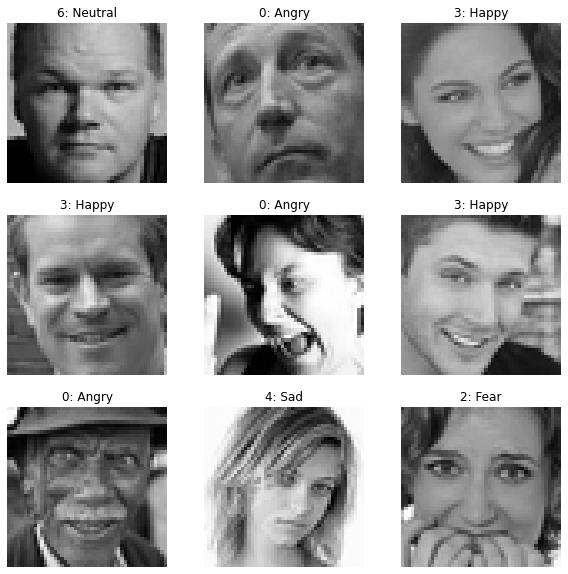

In [13]:
samples = np.random.choice(len(X_train), 9)
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for i, image in enumerate(X_train[samples]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image.astype(np.float32)/255)
    plt.title(
        f"{int(y_train[samples][i])}: {emotions[int(y_train[samples][i])]}")
    plt.axis("off")

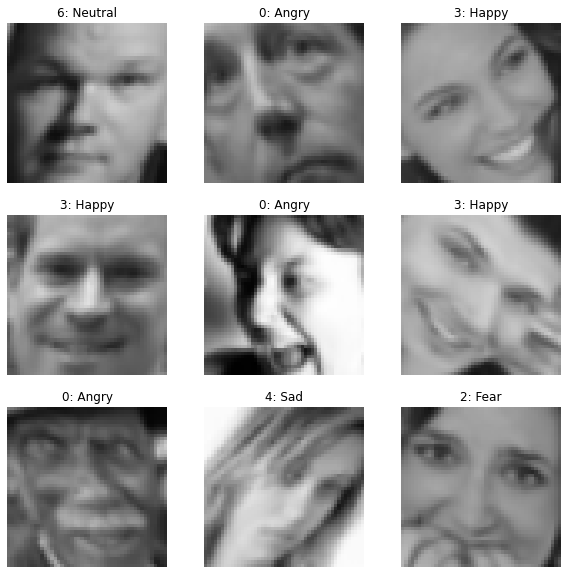

In [14]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for i, image in enumerate(X_train[samples]):
    image = augmentation_image(image)
    plt.subplot(3, 3, i + 1)
    plt.imshow(image.astype(np.float32)/255)
    plt.title(
        f"{int(y_train[samples][i])}: {emotions[int(y_train[samples][i])]}")
    plt.axis("off")